<a href="https://colab.research.google.com/github/dhsingh0815/ML/blob/main/Regression/Uber_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install termcolor

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error,r2_score
from warnings import filterwarnings
filterwarnings('ignore')
from datetime import datetime
from math import radians, sin, cos, acos
import io
import requests
from termcolor import colored


In [3]:
df =pd.read_csv('/content/uber.csv')
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


Column unnamed, key looks wrong data- **remove them**
Pickup_datetime - Date is not so important may be Day of week and Time in HH:MM would be helpful
Latitude and Longitude - we need to convert it to distance

In [4]:
df.drop(['Unnamed: 0','key'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        200000 non-null  float64
 1   pickup_datetime    200000 non-null  object 
 2   pickup_longitude   200000 non-null  float64
 3   pickup_latitude    200000 non-null  float64
 4   dropoff_longitude  199999 non-null  float64
 5   dropoff_latitude   199999 non-null  float64
 6   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 10.7+ MB


In [6]:
df.isnull().sum()

,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,1
dropoff_latitude,1
passenger_count,0


In [7]:
df.isna().sum()

,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,1
dropoff_latitude,1
passenger_count,0


In [8]:
df.shape

(200000, 7)

In [9]:
df.dropna(axis=0, inplace=True)

In [10]:
df.shape

(199999, 7)

In [11]:

def getDateTime(datetime_str):
  return datetime.strptime(datetime_str, '%m/%d/%y %H:%M:%S').day


In [71]:
def findschedule(x):
  if(x>7 and x<=19):
    return 0
  else:
    return 1

In [72]:

df['week_day']=pd.to_datetime(df['pickup_datetime']).dt.weekday.map(lambda x: 0 if(x<=4) else 1) # df['pickup_datetime'].apply(lambda datetime_str: datetime.strptime(datetime_str, '%y-%m-%d %H:%M').day)
df['pickup_hour']=pd.to_datetime(df['pickup_datetime']).dt.hour.map( lambda x: 0 if(x <=19) else 1 )
df['pickup_schedule']=pd.to_datetime(df['pickup_datetime']).dt.hour.map( lambda x: findschedule(x) )

In [73]:
def calculatedistance(row):
  try:
    mlat = radians(float(row['pickup_latitude']))
    mlon = radians(float(row['pickup_longitude']))
    plat = radians(float(row['dropoff_latitude']))
    plon = radians(float(row['dropoff_longitude']))
    #print(row.index)
    return round(6371.01 * acos( (sin(mlat)*sin(plat)) + (cos(mlat) * cos(plat) * (cos(mlon - plon))) ), 2)
  except:
    print('Errow while processing row {}',row[0])
    return None




In [74]:
df['distance_km']=df[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].apply(lambda row : calculatedistance(row) , axis=1)

In [75]:
df.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,week_day,pickup_hour,pickup_schedule,distance_km
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,0,0,0,1.68
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,0,1,1,2.46
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,0,1,1,5.04
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,0,0,0,1.66
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,0,0,0,4.48


In [76]:
df.isnull().sum()

,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
week_day,0
pickup_hour,0
pickup_schedule,0


In [77]:
df.isna().sum()

,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
week_day,0
pickup_hour,0
pickup_schedule,0


In [78]:
df.shape

(199948, 11)

In [79]:
df.dropna(axis=0, inplace=True)

In [80]:
df.shape

(199948, 11)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199948 entries, 0 to 199999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199948 non-null  float64
 1   pickup_datetime    199948 non-null  object 
 2   pickup_longitude   199948 non-null  float64
 3   pickup_latitude    199948 non-null  float64
 4   dropoff_longitude  199948 non-null  float64
 5   dropoff_latitude   199948 non-null  float64
 6   passenger_count    199948 non-null  int64  
 7   week_day           199948 non-null  int64  
 8   pickup_hour        199948 non-null  int64  
 9   pickup_schedule    199948 non-null  int64  
 10  distance_km        199948 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 18.3+ MB


I was thinking of coverting time to some sort of group of 3 or 4 hours , how to take that decision?

#Lets look at the distribution and correlation

In [82]:
df_selected = df[['distance_km','week_day','pickup_hour','passenger_count','fare_amount','pickup_schedule']]


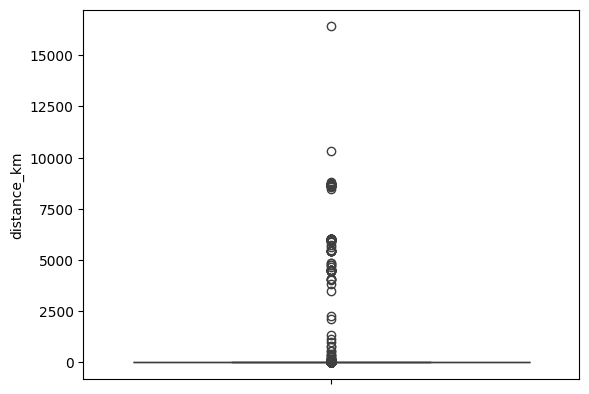

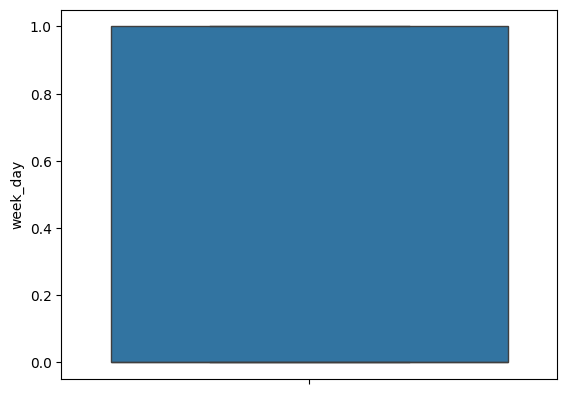

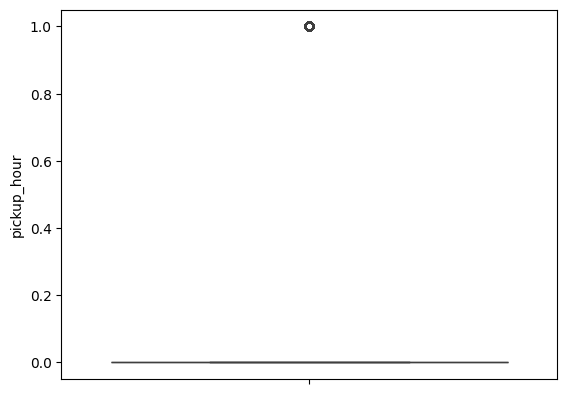

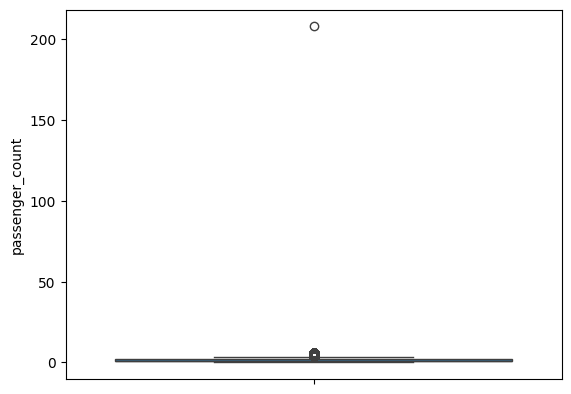

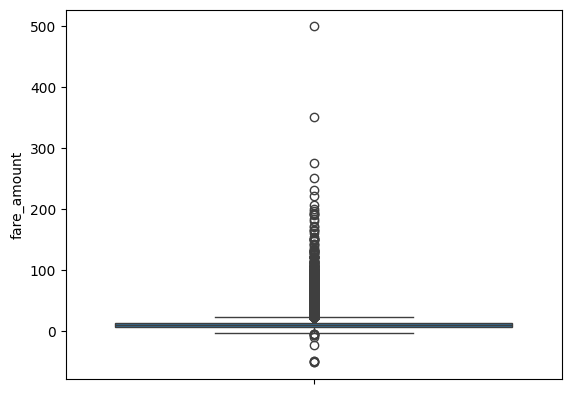

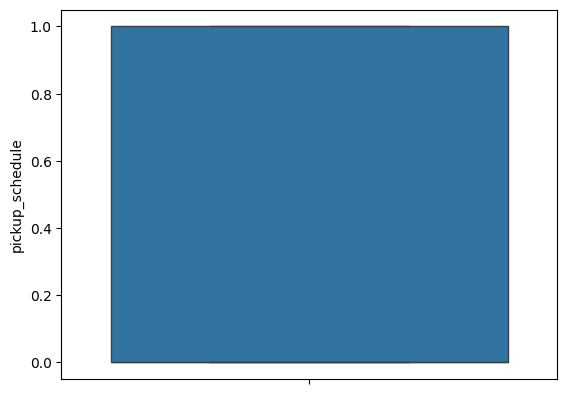

In [83]:
cols = df_selected.columns
for col in cols:
  sns.boxplot(df_selected[col])
  plt.show()

In [84]:
df_selected.describe()

,distance_km,week_day,pickup_hour,passenger_count,fare_amount,pickup_schedule
count,199948.000000,199948.000000,199948.000000,199948.000000,199948.000000,199948.000000
mean,20.860701,0.283469,0.220122,1.684568,11.358959,0.405786
std,383.013932,0.450683,0.414330,1.386026,9.896936,0.491045
min,0.000000,0.000000,0.000000,0.000000,-52.000000,0.000000
25%,1.220000,0.000000,0.000000,1.000000,6.000000,0.000000
50%,2.120000,0.000000,0.000000,1.000000,8.500000,0.000000
75%,3.880000,1.000000,0.000000,2.000000,12.500000,1.000000
max,16409.260000,1.000000,1.000000,208.000000,499.000000,1.000000


In [85]:
def remove_outliers(data_frame, series_col):
 Q1 = np.percentile(series_col, 25)
 Q3 = np.percentile(series_col, 75)
 IQR = Q3 - Q1
 Lower_Limit = Q1 - 1.5 * IQR
 Upper_Limit = Q3 + 1.5 * IQR
 data_frame = data_frame[(series_col >Lower_Limit) & (series_col < Upper_Limit)]
 return data_frame

In [86]:
df_selected=remove_outliers(df_selected,df_selected['fare_amount'])
df_selected=remove_outliers(df_selected,df_selected['distance_km'])
df_selected=remove_outliers(df_selected,df_selected['passenger_count'])

If you dont remove the outliers from distance_km column, the correlation is very bad 0.25.
After removing outliers from distance_km column , the correlation becomes 0.75

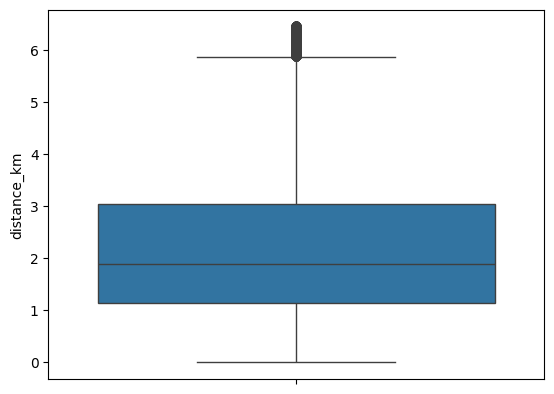

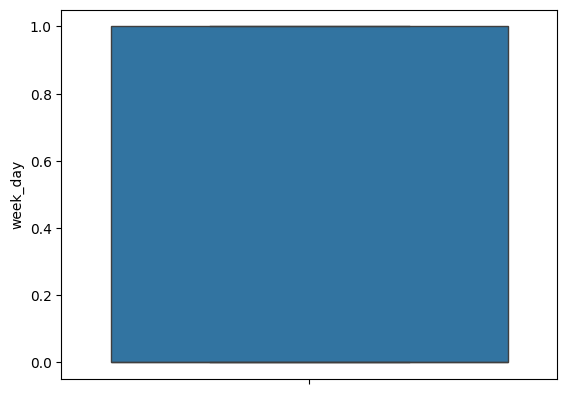

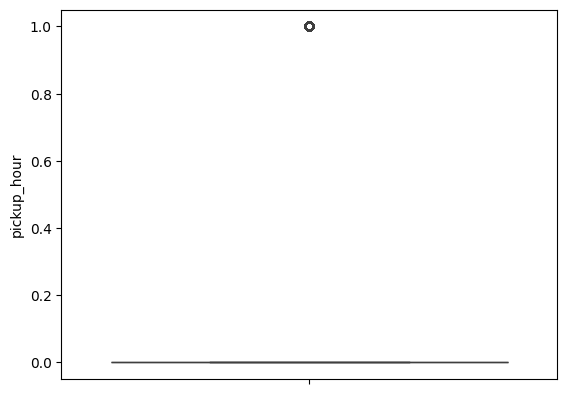

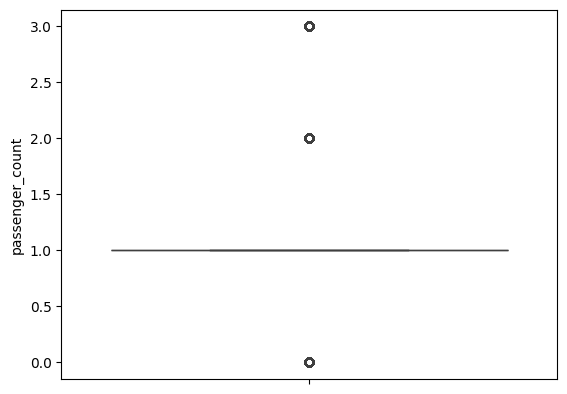

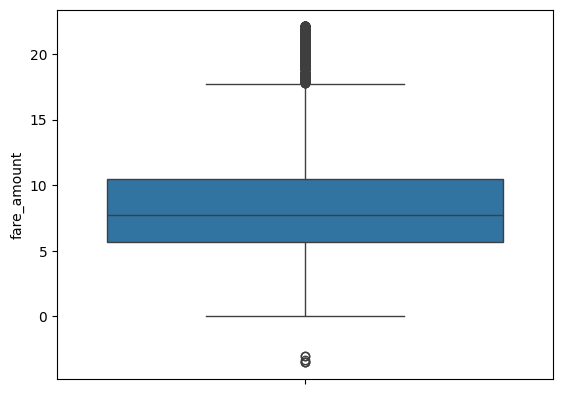

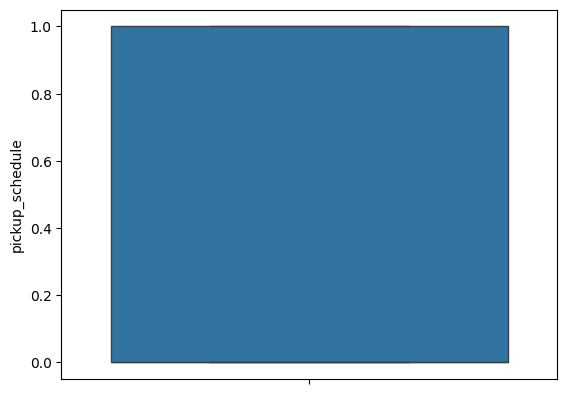

In [87]:
cols = df_selected.columns
for col in cols:
  sns.boxplot(df_selected[col])
  plt.show()

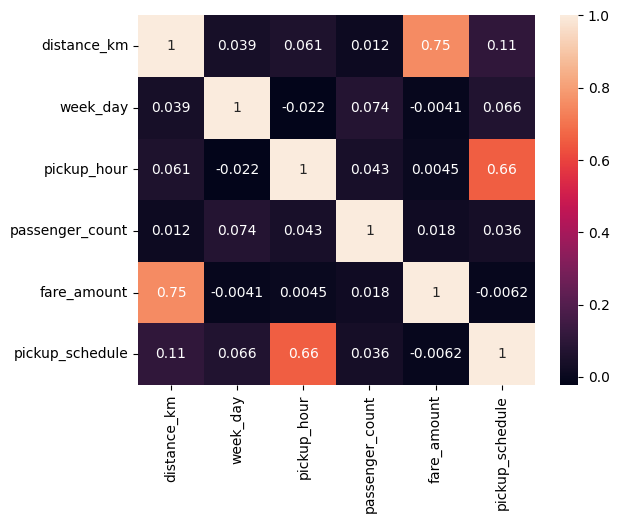

In [155]:
corr = df_selected.corr()
sns.heatmap(corr, annot=True)
plt.show()

Tried to convert pickup time hours into morning before 19 HRS , evening after 19 HRS. The correlation remains low at 0.0045. With just hours , it is 0.005.
With pick up day as week of day the correlation is 0.014, When it is gropued as weekdays and weekend (Saturday&Sunday), the correlation becomes -0.0041

# fare_amount and distance_km have a high correlation of 0.75.

In [159]:
df_selected.describe()

,distance_km,week_day,pickup_hour,passenger_count,fare_amount,pickup_schedule
count,154782.000000,154782.000000,154782.000000,154782.000000,154782.000000,154782.000000
mean,2.217096,0.277726,0.218139,1.259940,8.535336,0.393579
std,1.451903,0.447879,0.412984,0.548308,3.725384,0.488545
min,0.000000,0.000000,0.000000,0.000000,-3.500000,0.000000
25%,1.130000,0.000000,0.000000,1.000000,5.700000,0.000000
50%,1.880000,0.000000,0.000000,1.000000,7.700000,0.000000
75%,3.030000,1.000000,0.000000,1.000000,10.500000,1.000000
max,6.450000,1.000000,1.000000,3.000000,22.100000,1.000000


In [217]:
#X = df[['distance_km']]
#print(X.shape)
#X = np.array(df_selected['distance_km']).reshape(-1, 1)
X = df_selected[['distance_km','passenger_count']]
Y = np.array(df_selected['fare_amount']).reshape(-1, 1)
X_train, X_test,y_train,y_test = train_test_split(X,Y, test_size=0.2)

In [218]:
from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train,y_train)


LinearRegression()

In [219]:
y_pred_train=model.predict(X_train)
mean_sqr_err_train=mean_squared_error(y_pred=y_pred_train, y_true=y_train)
print('Mean Square Error om Training Data ',mean_sqr_err_train)
print('R2 Score Accuracy',r2_score(y_train,y_pred_train))

Mean Square Error om Training Data  5.982109890727989
R2 Score Accuracy 0.5697465135131061


In [220]:
y_pred_test=model.predict(X_test)
mean_sqr_err_test=mean_squared_error(y_pred=y_pred_test, y_true=y_test)
print('Mean Square Error om Test Data ',mean_sqr_err_train)
print('R2 Score Accuracy',r2_score(y_test,y_pred_test))

Mean Square Error om Test Data  5.982109890727989
R2 Score Accuracy 0.5696477465572083


We had correlation of 0.75 between fare_amount and distance_km, However there is quite large error in prediction and very low accuracy. So we should look at the how the fare_amount and distance_km are related , are they related linearly, Is applying LinearRegression correct?

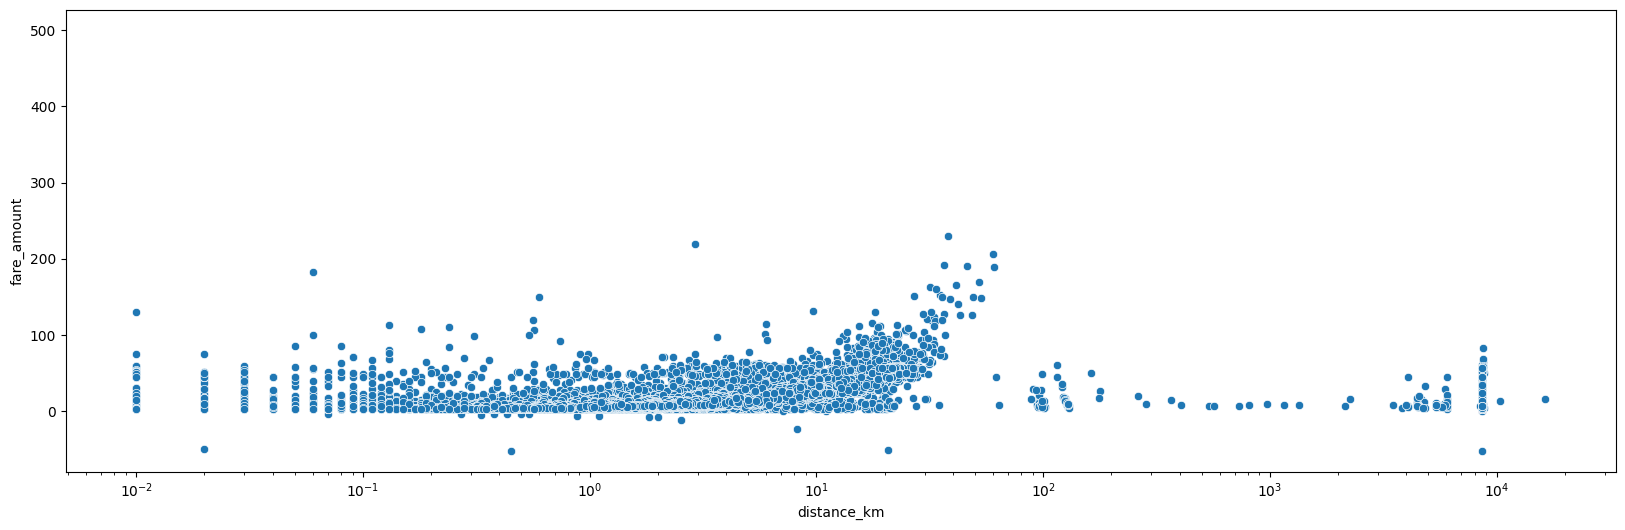

In [221]:
ax=sns.scatterplot(x=df['distance_km'],y=df['fare_amount'])
ax.set_xscale('log')
ax.figure.set_size_inches(20,6)
plt.show()


# From the graph we can see , its not a linear relationship. Lets try with Polynomial Linear Regression.

In [222]:
poly=PolynomialFeatures(degree=6)
X_poly_train=poly.fit_transform(X_train)
X_poly_test=poly.transform(X_test)
model = LinearRegression()
model.fit(X_poly_train, y_train)

LinearRegression()

In [223]:
y_pred_train=model.predict(X_poly_train)
mean_sqr_err_train=mean_squared_error(y_pred=y_pred_train, y_true=y_train)
print('Mean Square Error on Training Data ',mean_sqr_err_train)
print('R2 Score Accuracy',r2_score(y_train,y_pred_train))

Mean Square Error on Training Data  5.418086956443423
R2 Score Accuracy 0.6103129421423485


In [224]:
y_pred_test=model.predict(X_poly_test)
mean_sqr_err_test=mean_squared_error(y_pred=y_pred_test, y_true=y_test)
print('Mean Square Error on Test Data ',mean_sqr_err_train)
print('R2 Score Accuracy',r2_score(y_test,y_pred_test))

Mean Square Error on Test Data  5.418086956443423
R2 Score Accuracy 0.6100661981816636


# With Linear Regression, the accuracy was 57% , With Polynomial Linear Regression with degree 5, it increased to 61%. </br>
# There's very minimal change from 60 % to 61 % when passenger_count column is included. </br>
# The accuracy does not improve further if we increase degree beyond 6.
